In [2]:
%matplotlib inline
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, execute, BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
provider = IBMQ.load_account()

# Extração de propriedades dos backends da IBM Quantum

Esse notebook funciona melhor pelo Quantum Lab (não precisa instalar nada localmente, basta fazer login no IBM Quantum Experience e clicar em Launch Lab). Se preferirem usar o Qiskit localmente, pode usar o mesmo código, mas terão que copiar o API Token da conta de voces e colar dentro de IBMQ.load_account('colar_aqui');

In [59]:
IBMQ.load_account();
provider = IBMQ.get_provider(group='open')
# caso queiram utilizar o dispositivo com a menor fila
#from qiskit.providers.ibmq import least_busy
#backend = least_busy(provider.backends(simulator=False, filters=lambda b: b.configuration().n_qubits >= 5))

# escolhendo ibmq_belem para retirar infos
backend = provider.backend.ibmq_belem

ibmqfactory.load_account:WARNING:2021-11-26 15:33:12,784: Credentials are already in use. The existing account in the session will be replaced.


## Coupling map e a função transpiler()

Apenas pra mostrar como extrair o coupling map e o output do transpiler. Lembrando que cada SWAP é implementada com 3 CNOTs e em muitos casos são necessárias várias SWAPs pra "tornar dois qubits vizinhos". No caso do ibmq_belem, se quisermos aplicar uma CNOT entre q0 e q4, são necessárias 2 SWAPs (6 CNOTS) adicionais. 

## Gates de base

Em geral, são as mesmas pra todos os dispositivos (['id', 'rz', 'sx', 'x', 'cx', 'reset']). A função transpile() uma operação qualquer em uma combinação dos gates de base. Um exemplo é a operação hadamard que pode ser implementada como $Rz_{\pi/2}\sqrt{X}Rz_{\pi/2}$.


In [66]:
config = backend.configuration()
params = backend.properties()

print(config.coupling_map)
print(config.basis_gates)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
['id', 'rz', 'sx', 'x', 'cx', 'reset']


In [67]:
qc = QuantumCircuit(5)
qc.h(0)
qc.barrier()
qc.cx(0, 4)
mapped_circuit = transpile(qc, backend=backend)
job = backend.run(mapped_circuit, shots=1024)

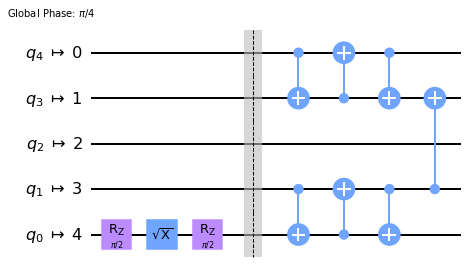

In [68]:
mapped_circuit.draw()

Fazendo a SWAP(0,1) e SWAP(3,4), os qubits q0 e q4 se tornaram "vizinhos".

## Vizualização alto nível de algumas propriedades

In [34]:
backend

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

## Extração de propriedades e parâmetros de qubits e gates

Pra conseguirmos acessar valores ou propriedades individualmente podemos utilizar backend.properties() ou backend.configuration(), que já foram definidos como params e config lá em cima. 

In [10]:
#NOME
backend.properties().backend_name

'ibmq_belem'

## Informações dos qubits

In [75]:
qubits_info = backend.properties().qubits
#EXEMPLO: info do qubit q0
qubits_info[0]

[Nduv(datetime.datetime(2021, 11, 26, 5, 29, 29, tzinfo=tzlocal()), T1, us, 101.37763270227741),
 Nduv(datetime.datetime(2021, 11, 26, 5, 34, 10, tzinfo=tzlocal()), T2, us, 116.39227469806245),
 Nduv(datetime.datetime(2021, 11, 26, 6, 20, 36, tzinfo=tzlocal()), frequency, GHz, 5.090161412517565),
 Nduv(datetime.datetime(2021, 11, 26, 6, 20, 36, tzinfo=tzlocal()), anharmonicity, GHz, -0.33612300518216515),
 Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), readout_error, , 0.07109999999999994),
 Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), prob_meas0_prep1, , 0.122),
 Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), prob_meas1_prep0, , 0.0202),
 Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), readout_length, ns, 5351.11111111111)]

In [76]:
#info de tosos os qubits
qubits_info

[[Nduv(datetime.datetime(2021, 11, 26, 5, 29, 29, tzinfo=tzlocal()), T1, us, 101.37763270227741),
  Nduv(datetime.datetime(2021, 11, 26, 5, 34, 10, tzinfo=tzlocal()), T2, us, 116.39227469806245),
  Nduv(datetime.datetime(2021, 11, 26, 6, 20, 36, tzinfo=tzlocal()), frequency, GHz, 5.090161412517565),
  Nduv(datetime.datetime(2021, 11, 26, 6, 20, 36, tzinfo=tzlocal()), anharmonicity, GHz, -0.33612300518216515),
  Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), readout_error, , 0.07109999999999994),
  Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), prob_meas0_prep1, , 0.122),
  Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), prob_meas1_prep0, , 0.0202),
  Nduv(datetime.datetime(2021, 11, 26, 5, 28, 55, tzinfo=tzlocal()), readout_length, ns, 5351.11111111111)],
 [Nduv(datetime.datetime(2021, 11, 26, 5, 29, 29, tzinfo=tzlocal()), T1, us, 100.40316747046508),
  Nduv(datetime.datetime(2021, 11, 26, 5, 35, 16, tzinfo=tzlocal()), T2, us, 

## Informações das single-qubit gates

In [85]:
#EXEMPLO: calcular tempo de duração e erro da porta SX para cada qubit
for qubit in range(config.n_qubits):
    print("qubit: ",qubit, "DURAÇÃO: ", params.gate_length('sx',qubit), "ERRO: ", params.gate_error('sx',qubit))

qubit:  0 DURAÇÃO:  3.5555555555555554e-08 ERRO:  0.0007718408178957369
qubit:  1 DURAÇÃO:  3.5555555555555554e-08 ERRO:  0.0010457516495022813
qubit:  2 DURAÇÃO:  3.5555555555555554e-08 ERRO:  0.0002510409094420984
qubit:  3 DURAÇÃO:  3.5555555555555554e-08 ERRO:  0.00024791955323611565
qubit:  4 DURAÇÃO:  3.5555555555555554e-08 ERRO:  0.00023453147905543907


## Informações da CNOT
Apenas entre qubits interconectados

In [96]:
for qubits in config.coupling_map:
    print(qubits,"DURAÇÃO: ", params.gate_length('cx',qubits), "ERRO: ", params.gate_error('cx',qubits))

[0, 1] DURAÇÃO:  8.106666666666666e-07 ERRO:  0.030576268549815266
[1, 0] DURAÇÃO:  7.751111111111111e-07 ERRO:  0.030576268549815266
[1, 2] DURAÇÃO:  4.48e-07 ERRO:  0.007840589637344603
[1, 3] DURAÇÃO:  4.337777777777778e-07 ERRO:  0.008789190071562397
[2, 1] DURAÇÃO:  4.124444444444444e-07 ERRO:  0.007840589637344603
[3, 1] DURAÇÃO:  3.9822222222222215e-07 ERRO:  0.008789190071562397
[3, 4] DURAÇÃO:  5.902222222222222e-07 ERRO:  0.008410322263388836
[4, 3] DURAÇÃO:  5.546666666666667e-07 ERRO:  0.008410322263388836


## Informações do canal

In [82]:
config.hamiltonian

{'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\n\nQuantities are returned in angular frequencies, with units 2*pi*GHz.\n\nWARNING: Currently not all system Hamiltonian information is available